In [1]:
%matplotlib inline

import numpy as np
import keras

from keras.layers import Input, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

import matplotlib.pyplot as plt

from sklearn import preprocessing

# np.random.seed(1)

Using TensorFlow backend.


###### Load featuers

In [2]:
features = np.genfromtxt('features.csv', delimiter=',')
np.random.shuffle(features)

In [3]:
n_rows, n_cols = features.shape
print("Number of rows: " + str(n_rows))
print("Number of cols: " + str(n_cols))

Number of rows: 8418
Number of cols: 376


In [4]:
encoding_dim = 64
layer_dim = 128

###### Autoencoder

In [5]:
dropout_rate = 0.1
alpha = 0.3

input_features = Input(shape=(n_cols,), name="autoencoder_input")
encoder = Dense(layer_dim, activation="linear", name="encoder_first_layer")(input_features)
encoder = LeakyReLU(alpha=alpha)(encoder)
encoder = Dropout(dropout_rate, name="encoder_first_layer_dropout")(encoder)
encoder = Dense(encoding_dim, activation="linear")(encoder)
encoder = LeakyReLU(alpha=alpha)(encoder)
encoder = Dropout(dropout_rate, name="encoder")(encoder)

decoder = Dense(layer_dim, activation="linear", name="decoder_first_layer")(encoder)
decoder = LeakyReLU(alpha=alpha)(decoder)
decoder = Dropout(dropout_rate, name="decoder_first_layer_dropout")(decoder)
decoder = Dense(n_cols, name="decoder")(decoder)
autoencoder = Model(input_features, decoder)

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 376)               0         
_________________________________________________________________
encoder_first_layer (Dense)  (None, 128)               48256     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
encoder_first_layer_dropout  (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
encoder (Dropout)            (None, 64)                0         
__________

###### Encoder

In [7]:
encoder = Model(input_features, encoder)

###### Decoder

In [8]:
encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.get_layer("decoder_first_layer")(encoded_input)
decoder_layer = autoencoder.get_layer("decoder")(decoder_layer)

decoder = Model(encoded_input, decoder_layer)

In [9]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
decoder_first_layer (Dense)  (None, 128)               8320      
_________________________________________________________________
decoder (Dense)              (None, 376)               48504     
Total params: 56,824
Trainable params: 56,824
Non-trainable params: 0
_________________________________________________________________


###### Compile models

In [10]:
#loss="mean_squared_error"
loss="mean_absolute_error"
autoencoder.compile(optimizer="adadelta", loss=loss)

###### Test - train split

In [11]:
ts = 0.2 # Test size
vs = 0.5 # Validation data size (as % of the test data).

# normalizer = preprocessing.Normalizer().fit(features)
# features = normalizer.transform(features)

train = features[0:int((1 - ts)*n_rows),:]
test = features[int((1 - ts)*n_rows):,:]

# Half of the test set will serve as the validation set.
# The other half will be the test set.
valid = test[0:int(len(test)/2),:]
test = test[int(len(test)/2):,:]

n_rows_train, n_cols_train = train.shape
n_rows_valid, n_cols_valid = valid.shape
n_rows_test, n_cols_test = test.shape

print("Train shape: " + str(train.shape))
print("Valid shape: " + str(valid.shape))
print("Test shape: " + str(test.shape))
print("Total number of rows: " + str(n_rows_train + n_rows_test + n_rows_valid))
print("Expected number of rows: " + str(n_rows))

Train shape: (6734, 376)
Valid shape: (842, 376)
Test shape: (842, 376)
Total number of rows: 8418
Expected number of rows: 8418


###### Training the autoencoder

In [12]:
autoencoder.fit(train, train,
                epochs=20000,
                batch_size=1024,
                shuffle=True,
                verbose=0,
                validation_data=(valid, valid))

###### Evaluate model

In [13]:
autoencoder.evaluate(train, train, verbose=0)

0.049097771571303531

In [14]:
autoencoder.evaluate(valid, valid, verbose=0)

0.049612946507483366

In [15]:
autoencoder.evaluate(test, test, verbose=0)

0.049057325405774378

###### Visualize the encoder/decoder performance

In [16]:
def plot_bars(true, decoded):
    
    n_cols = true.size
    
    x_axis = np.arange(n_cols)
    width = 0.2

    fig, ax = plt.subplots(figsize=(20, 20))
    
    print("true size: " + str(true.shape))
    print("decoded size: " + str(decoded.shape))
    
    rects1 = ax.bar(x_axis, true, width, color="r")
    rects2 = ax.bar(x_axis + width, decoded, width, color='b')
    ax.legend((rects1[0], rects2[0]), ("True", "Decoded"))
    plt.show()
    
def encode_decode(index):
    single_input = np.reshape(test[index,:],(1,-1))

    en = encoder.predict(single_input)
    print(en)

    dc = decoder.predict(en)

    true_input = np.reshape(test[index,:], (-1))
    decoded_input = np.reshape(dc, (-1))

    print(true_input.shape)
    print(decoded_input.shape)


    plot_bars(true_input[0:100], decoded_input[0:100])
    plot_bars(true_input[100:200], decoded_input[100:200])
    plot_bars(true_input[200:300], decoded_input[200:300])
    plot_bars(true_input[300:], decoded_input[300:])

[[ -3.77893269e-01  -8.51265788e-02   2.95589304e+00  -2.30187178e-03
   -2.16104854e-02   1.22294188e+00  -2.31701713e-02   2.73848176e+00
   -8.30334872e-02  -8.11677426e-02   1.61726391e+00   3.30846739e+00
    2.61000842e-01   4.16269213e-01  -3.54497917e-02  -2.36409549e-02
   -8.48357007e-02   1.05899259e-01  -4.45253477e-02   1.96862721e+00
   -1.13825455e-01   9.65713263e-01   4.50365067e-01  -1.25115871e-01
   -7.74477869e-02  -2.28626117e-01  -3.80122615e-03   9.48445201e-01
   -1.05530359e-01  -7.45037869e-02  -1.28358215e-01  -3.36930692e-01
   -1.43667430e-01  -4.74300347e-02  -1.06321372e-01  -9.33722556e-02
   -1.79428563e-01   1.48758256e+00  -1.19040556e-01  -1.14821605e-01
   -1.99761316e-01   7.23115563e-01  -1.01278678e-01   1.66100538e+00
    8.27582717e-01   5.65345772e-02   6.50569379e-01   1.13892233e+00
    2.39551878e+00  -1.75747171e-01   4.61045325e-01  -2.46225938e-01
   -4.91666943e-01  -1.99947610e-01   8.54241908e-01   2.27283686e-03
    2.77897525e+00  

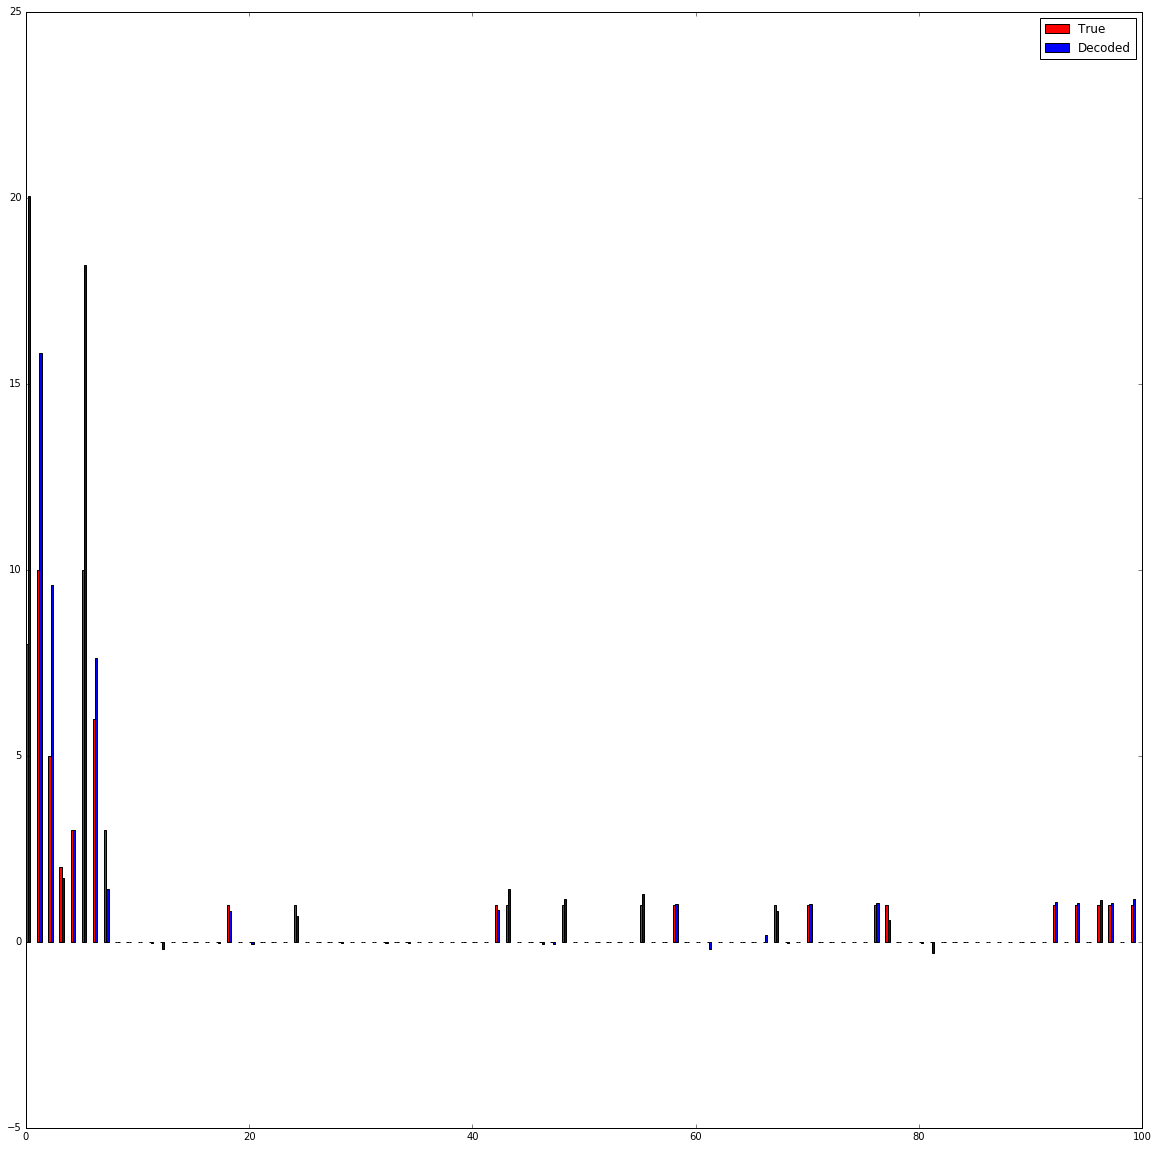

true size: (100,)
decoded size: (100,)


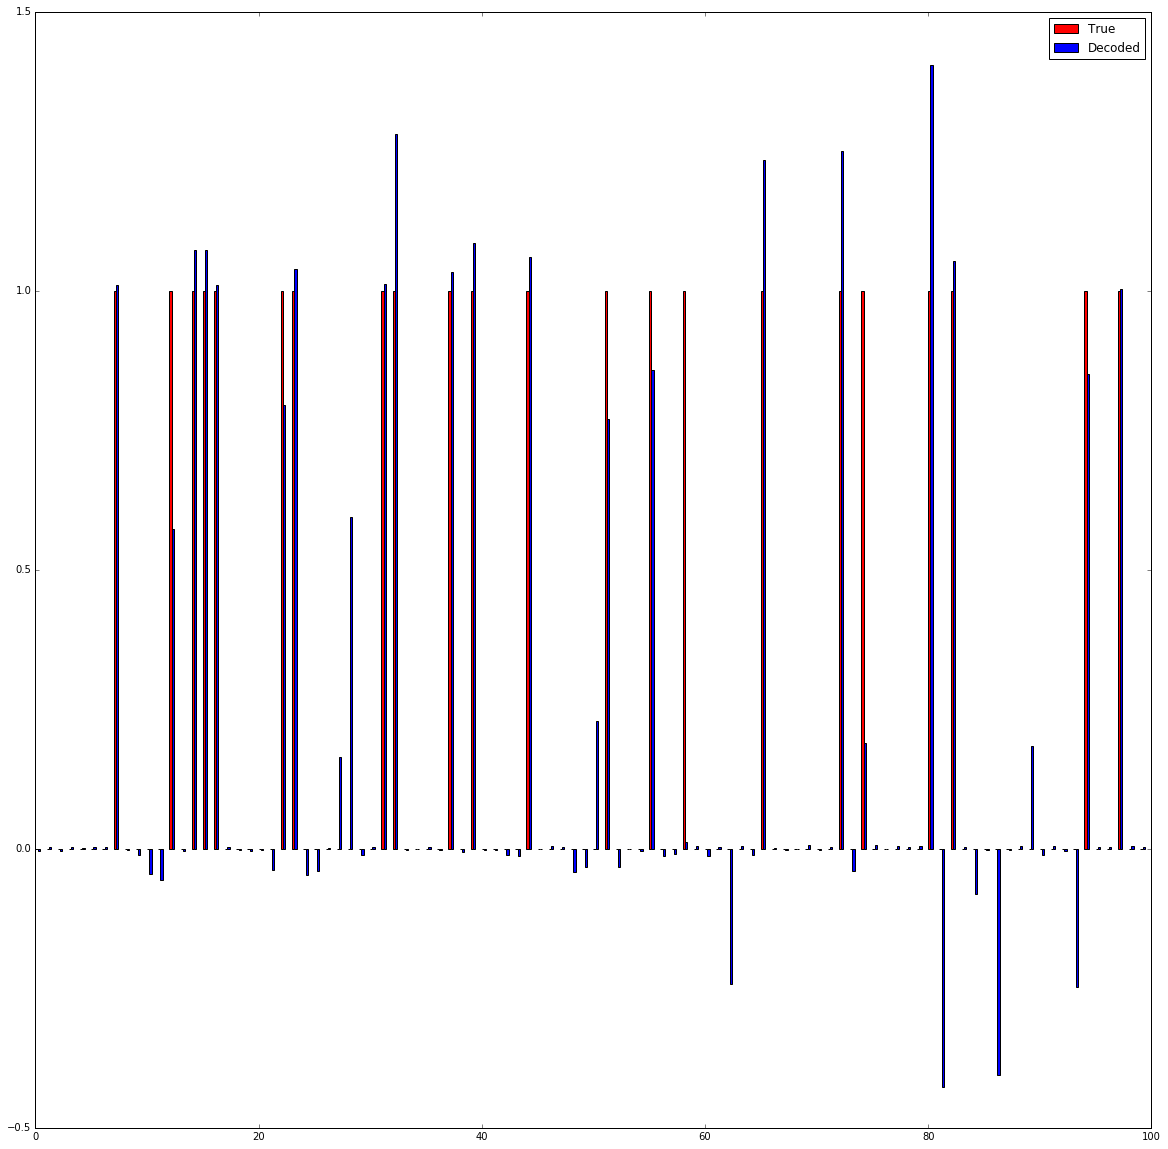

true size: (100,)
decoded size: (100,)


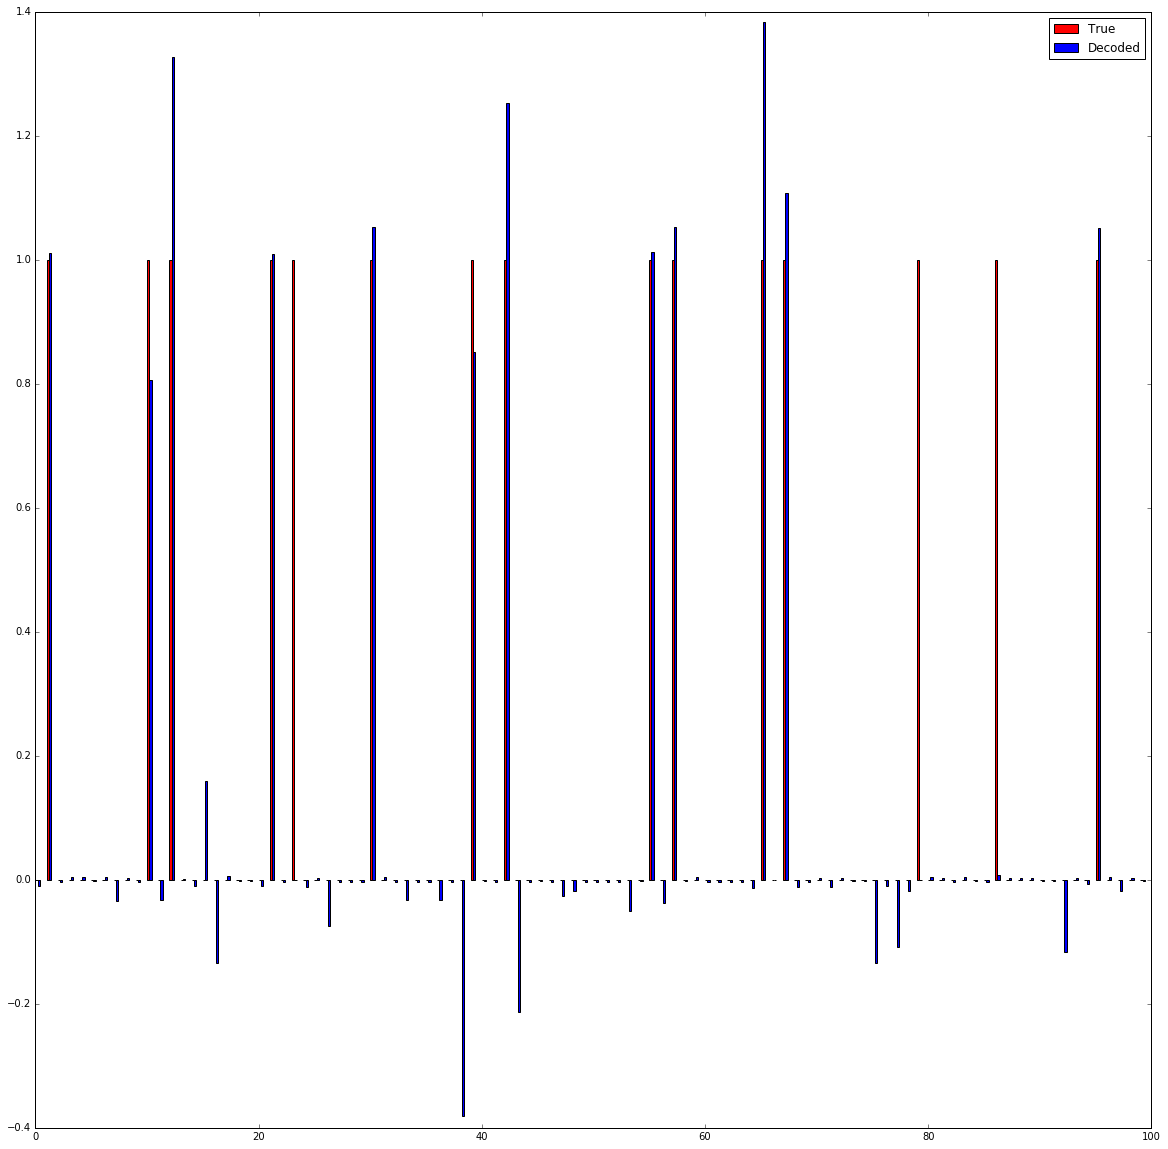

true size: (76,)
decoded size: (76,)


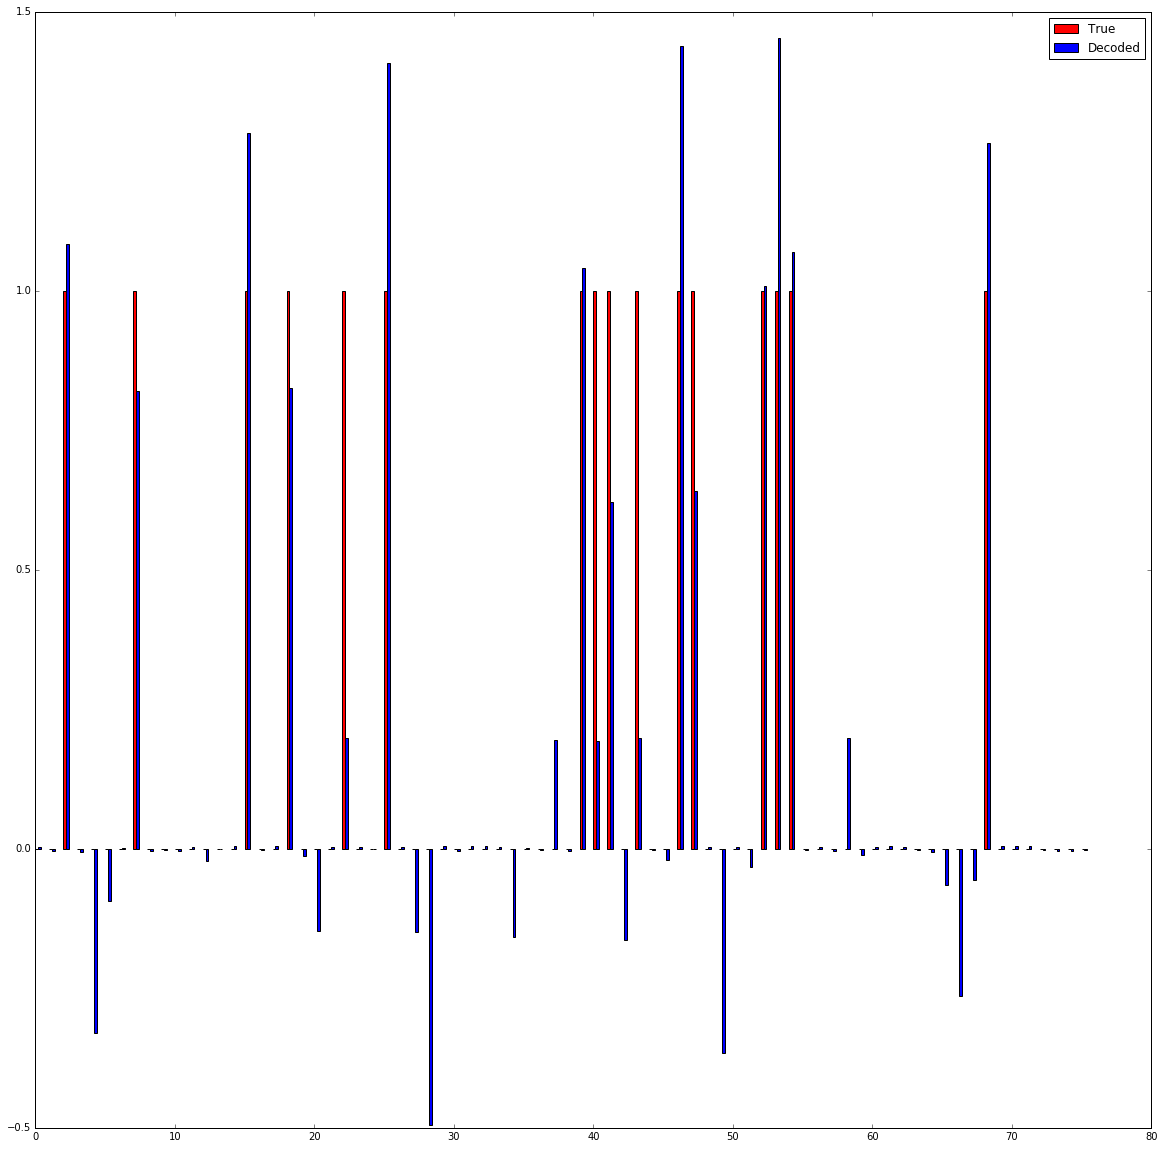

[[  1.54122889e-01  -1.25492871e-01   1.56260610e+00   1.01605880e+00
    2.20619202e+00   1.02329361e+00   9.24862385e-01   6.53323352e-01
   -6.57570437e-02  -1.20739035e-01   1.48562360e+00   3.18871140e+00
   -2.19725832e-01   3.79210860e-01   1.81605250e-01   8.20528746e-01
   -2.62343645e-01  -4.34749871e-01  -1.11367024e-01   1.83025718e+00
   -3.08798533e-02  -1.74932376e-01  -3.68857682e-02  -8.84977207e-02
   -2.74640333e-04  -1.26542494e-01   5.57624325e-02  -2.28480816e-01
   -8.13546404e-02  -7.23377243e-02   1.23839307e+00  -1.56626135e-01
   -1.46402523e-01   1.01516163e+00  -1.57314748e-01   8.98013294e-01
   -1.91300347e-01   1.72693348e+00   5.33815682e-01  -5.04330546e-02
   -1.30814254e-01   7.10390508e-01  -1.35869294e-01   1.67904902e+00
    8.22345793e-01  -7.82423615e-02   1.76463425e-01  -8.62619430e-02
    2.15753603e+00  -1.30715966e-01  -1.38794065e-01  -1.31810308e-01
   -7.69081354e-01  -3.38502228e-01  -6.10868558e-02   1.63455999e+00
    2.66458297e+00  

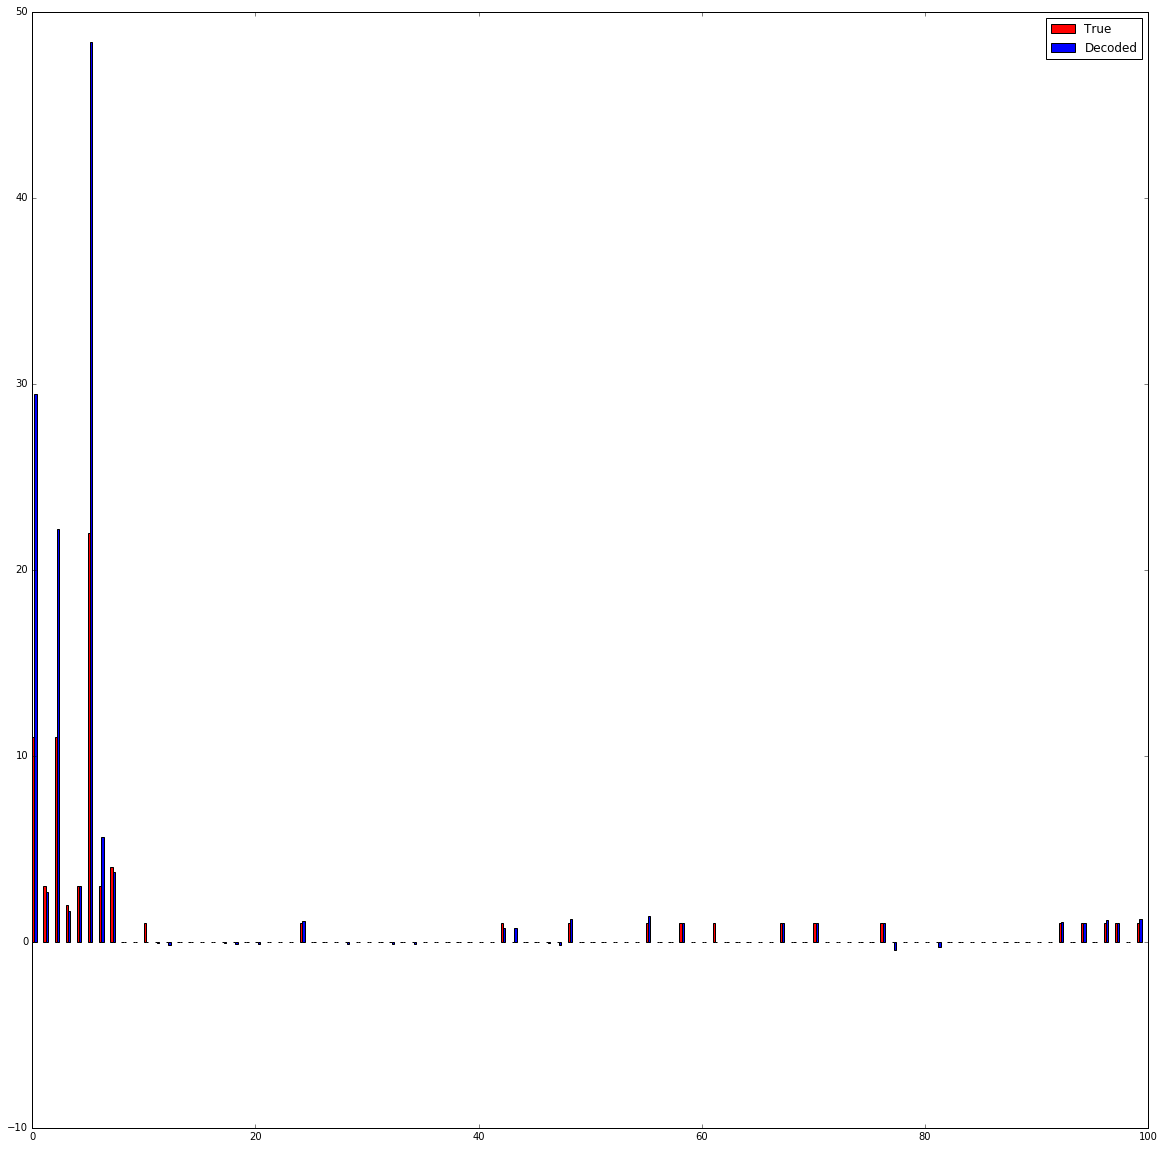

true size: (100,)
decoded size: (100,)


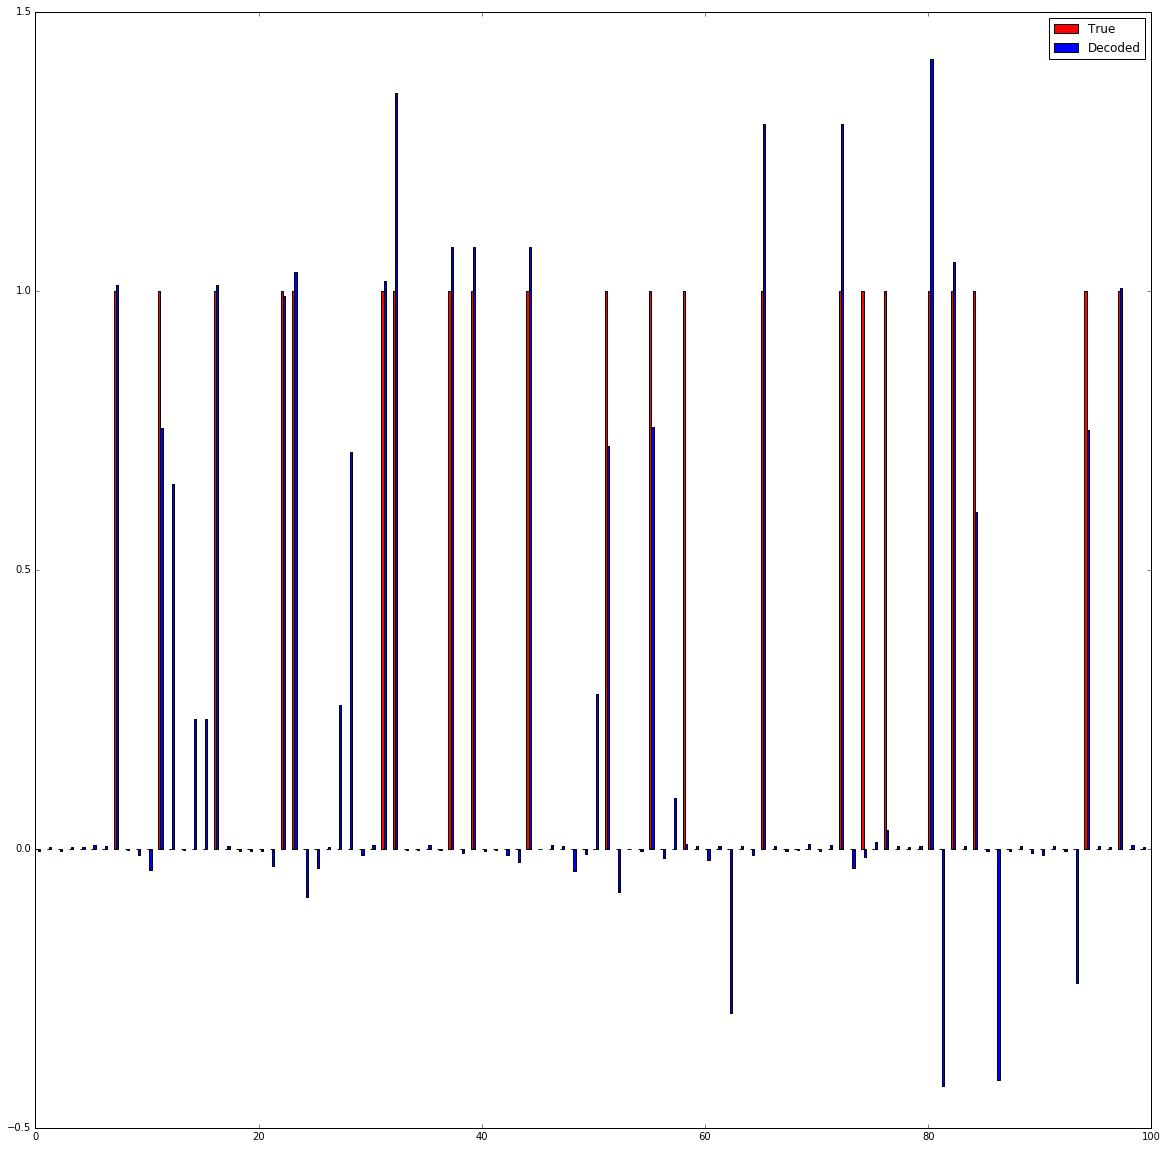

true size: (100,)
decoded size: (100,)


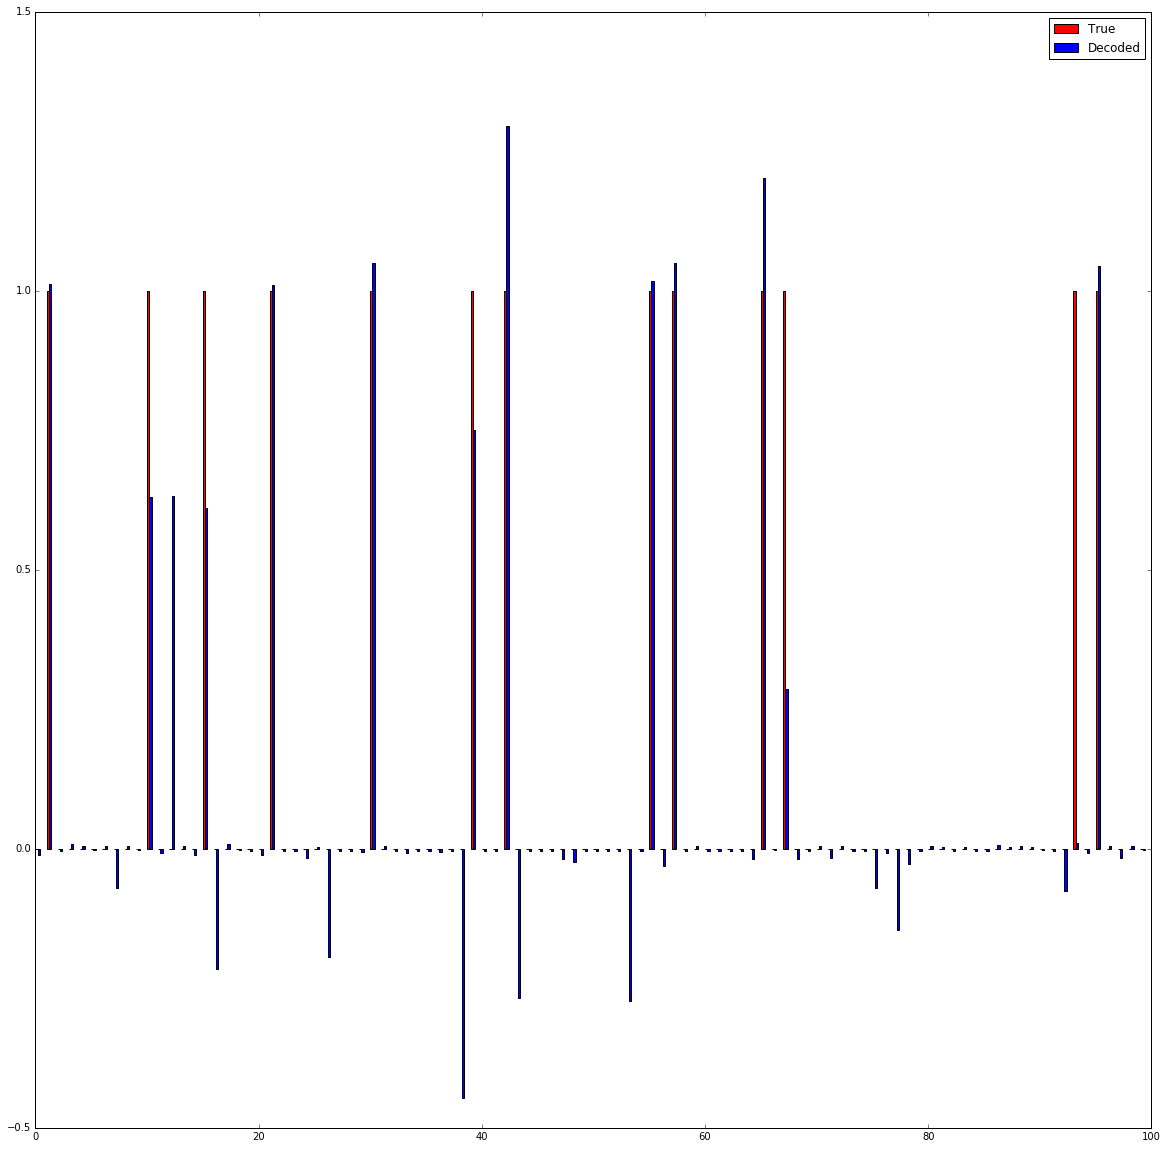

true size: (76,)
decoded size: (76,)


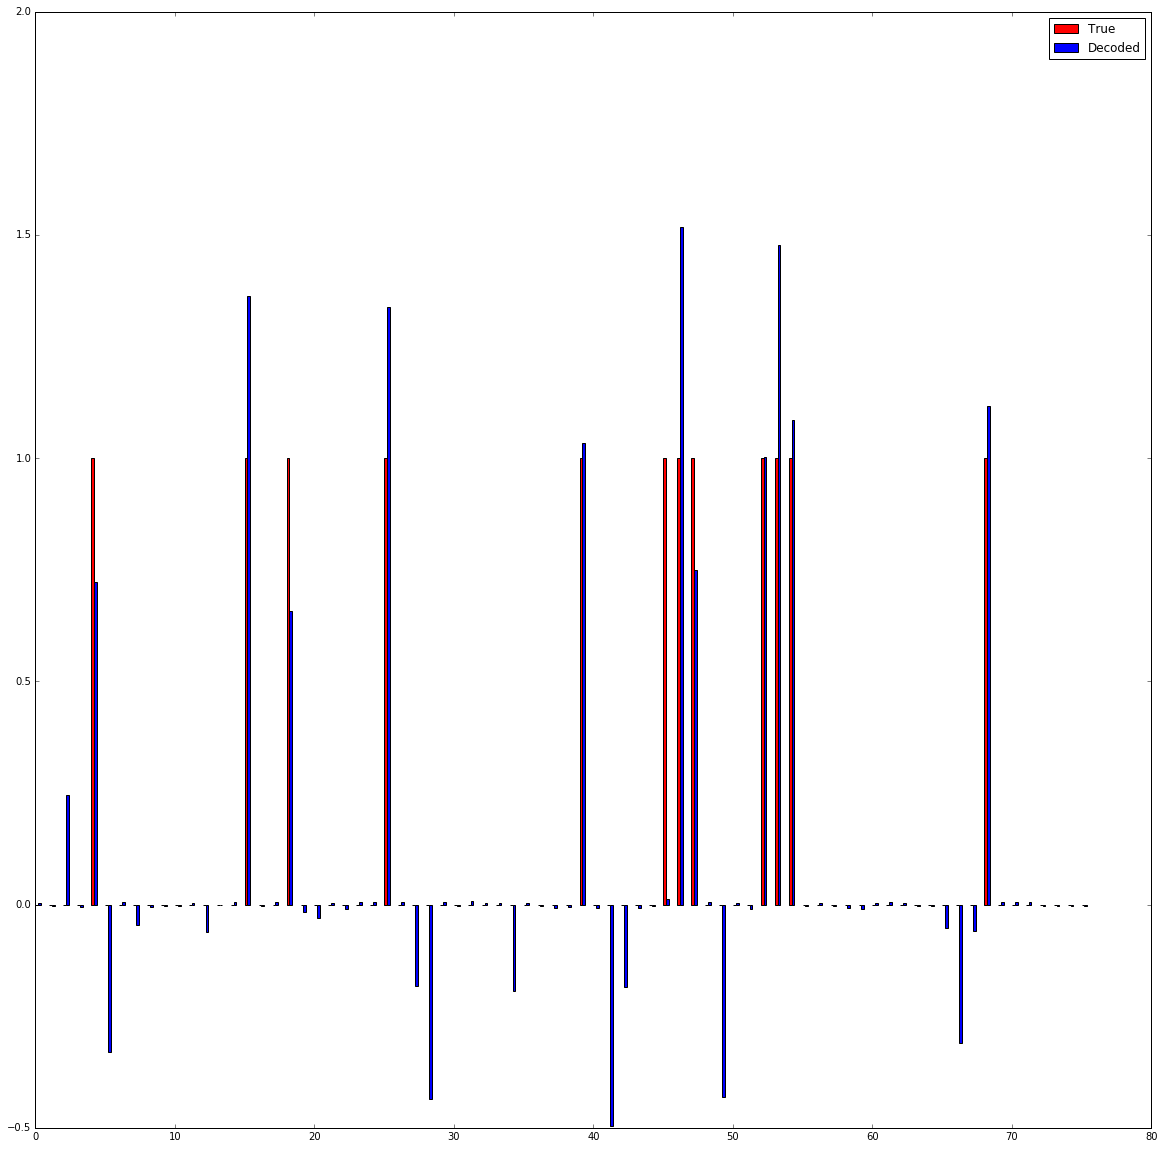

[[-0.61374408 -0.08482969  2.32799911  1.38459969 -0.11303054 -0.14116918
   0.03618179  1.11167955 -0.10022331 -0.05179003 -0.2443554  -0.19757141
  -0.08789705  0.02426416 -0.10510091  1.17339015  2.46528697 -0.03448559
  -0.06665831  2.24281549  1.35619795  1.79989028  0.50985187 -0.20497446
  -0.06113058 -0.05744576  0.16190113  1.94840002 -0.04876584 -0.07841252
  -0.39356416 -0.0303753  -0.07457772  1.19969118 -0.12442614 -0.11417241
  -0.12800765 -0.30211899  0.10150695 -0.07506481  0.84853798  0.49696821
  -0.12386128 -0.12458158 -0.06609865 -0.02781084 -0.02451094 -0.12700535
   1.97415876 -0.09148637 -0.22751178  2.55189109 -0.16712582 -0.11650383
  -0.09368877  0.79009145 -0.25289598 -0.06058097 -0.31428504 -0.06682963
  -0.0885978  -0.05435956 -0.05154783 -0.03140222]]
(376,)
(376,)
true size: (100,)
decoded size: (100,)


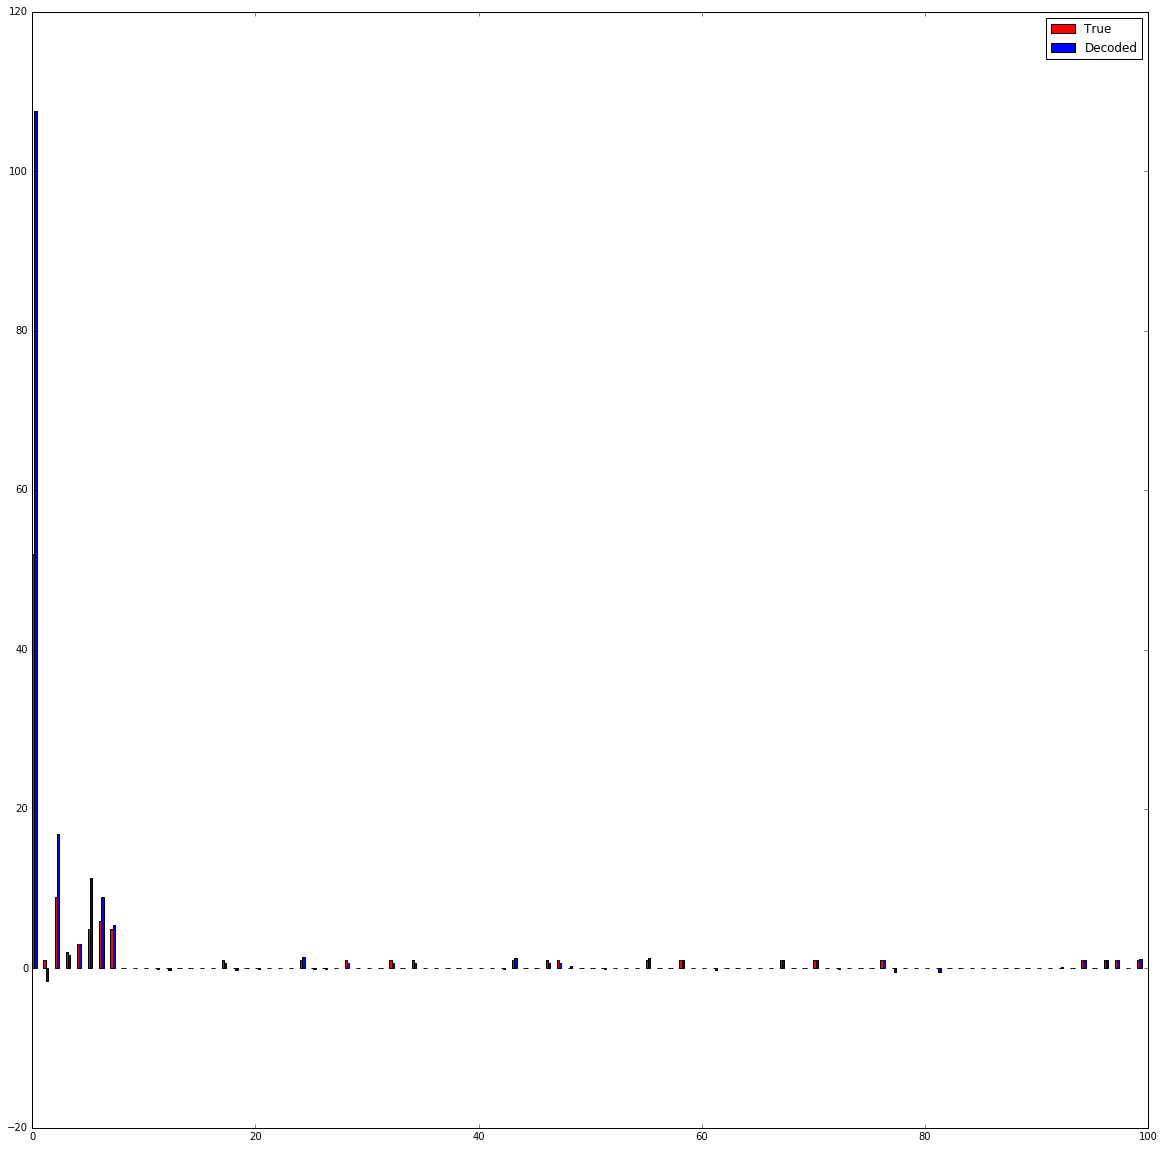

true size: (100,)
decoded size: (100,)


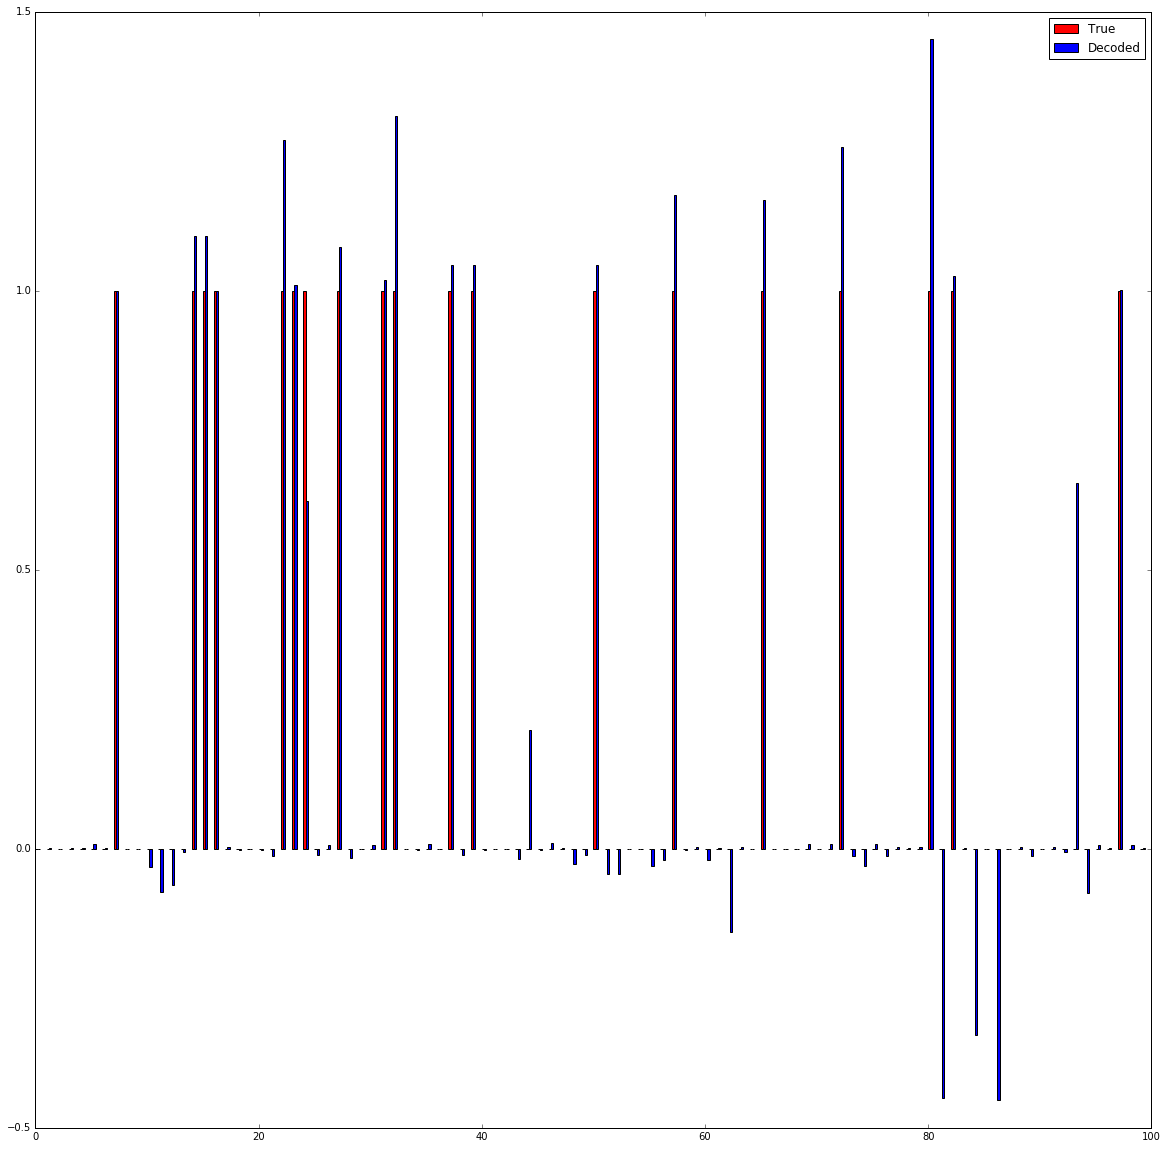

true size: (100,)
decoded size: (100,)


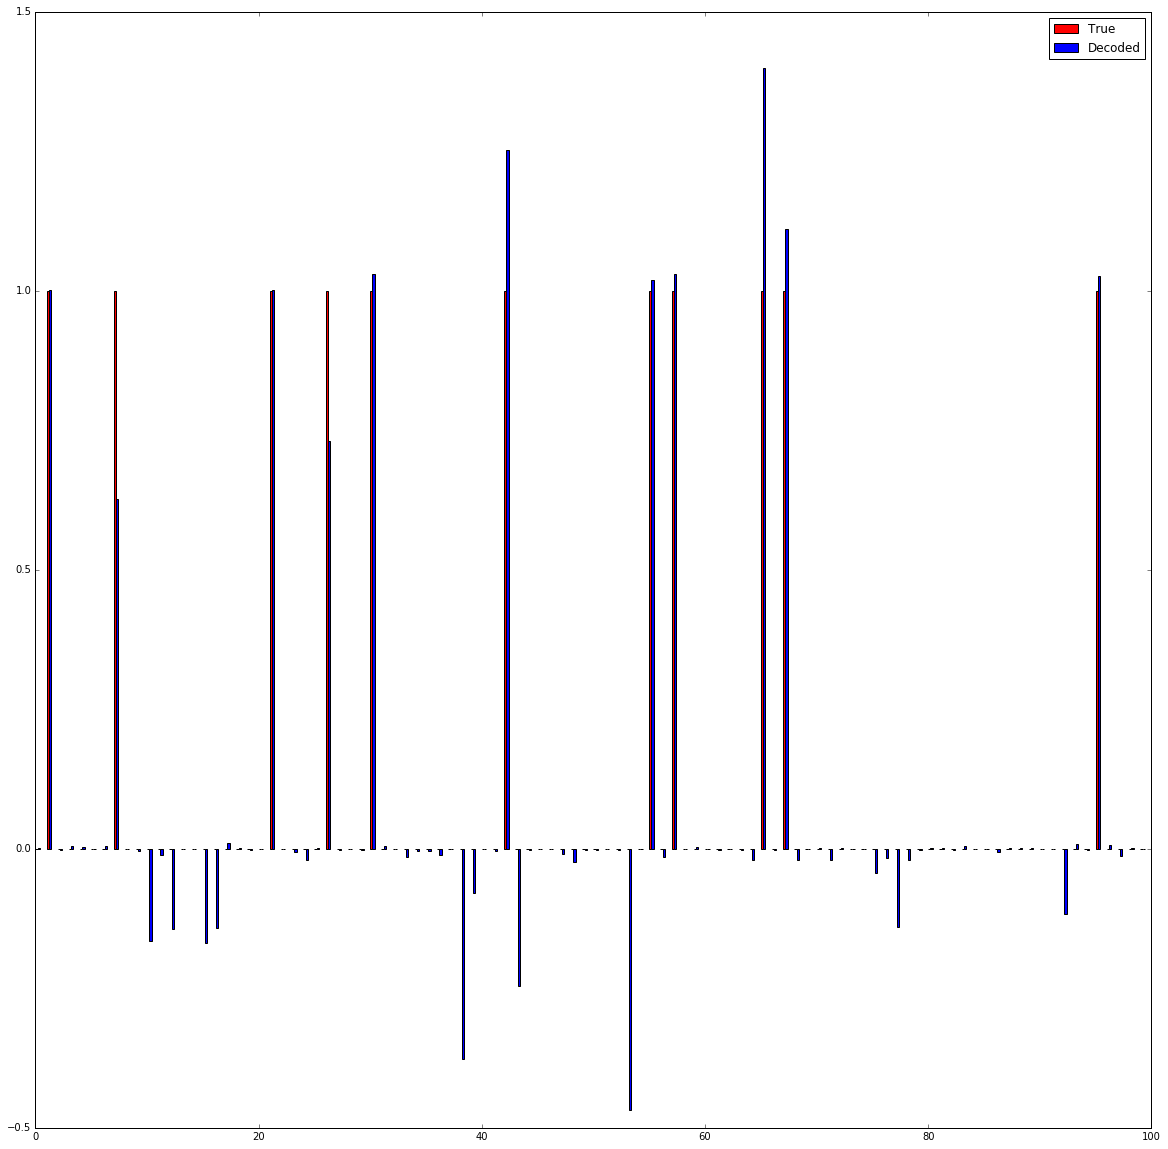

true size: (76,)
decoded size: (76,)


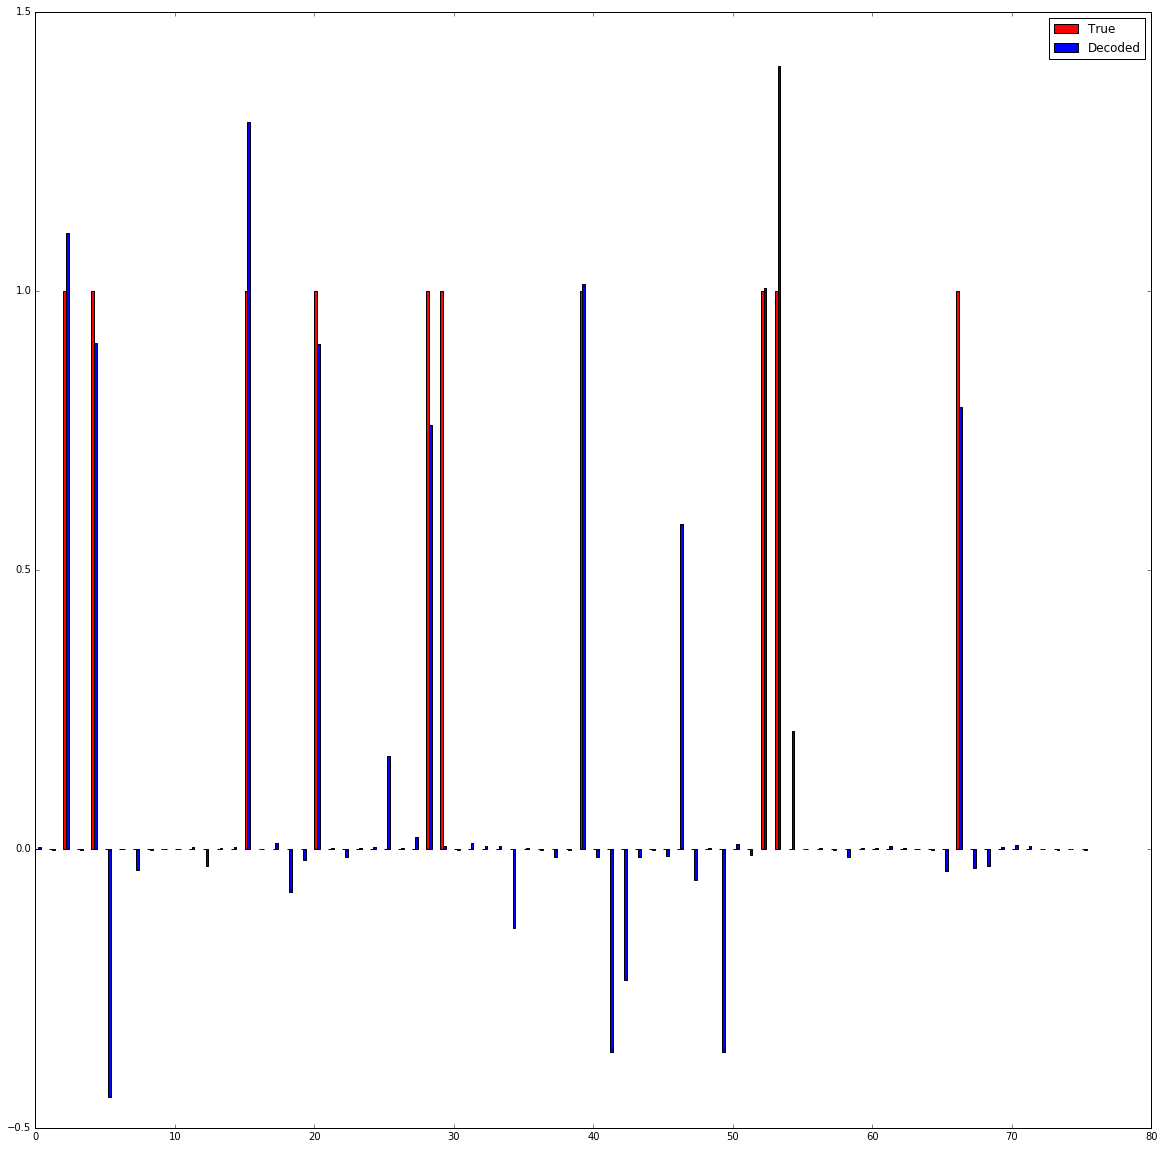

[[ 0.63350898 -0.1000993  -0.34803611  0.92549038  1.8487283   0.57576865
  -0.0876018  -0.32506153  2.52962494 -0.08093439  0.48637307  1.22468507
  -0.40746954 -0.26165804 -0.071649    0.86726755 -0.1868396   0.96018672
  -0.07346468 -0.36914095 -0.35796475 -0.14513287 -0.41501075  1.82372069
   2.05211592 -0.18601021 -0.667781   -0.19202502 -0.14891481 -0.59126526
   0.76806831 -0.30819559 -0.08351839  1.32959282 -0.21411219 -0.06711817
  -0.16287799  0.7855311   1.38723385  0.40269125 -0.19870155 -0.81721288
  -0.12615189  0.69306898  0.84806061  0.05065205  0.61070967  1.09972072
  -0.66766298 -0.0149788  -0.07952216 -0.0829775  -0.23359878  2.46203828
  -0.12852059 -0.27857572  0.27012482 -0.09956584 -0.11717448 -0.20030351
  -0.07452482 -0.20649837  0.76939654 -0.57941276]]
(376,)
(376,)
true size: (100,)
decoded size: (100,)


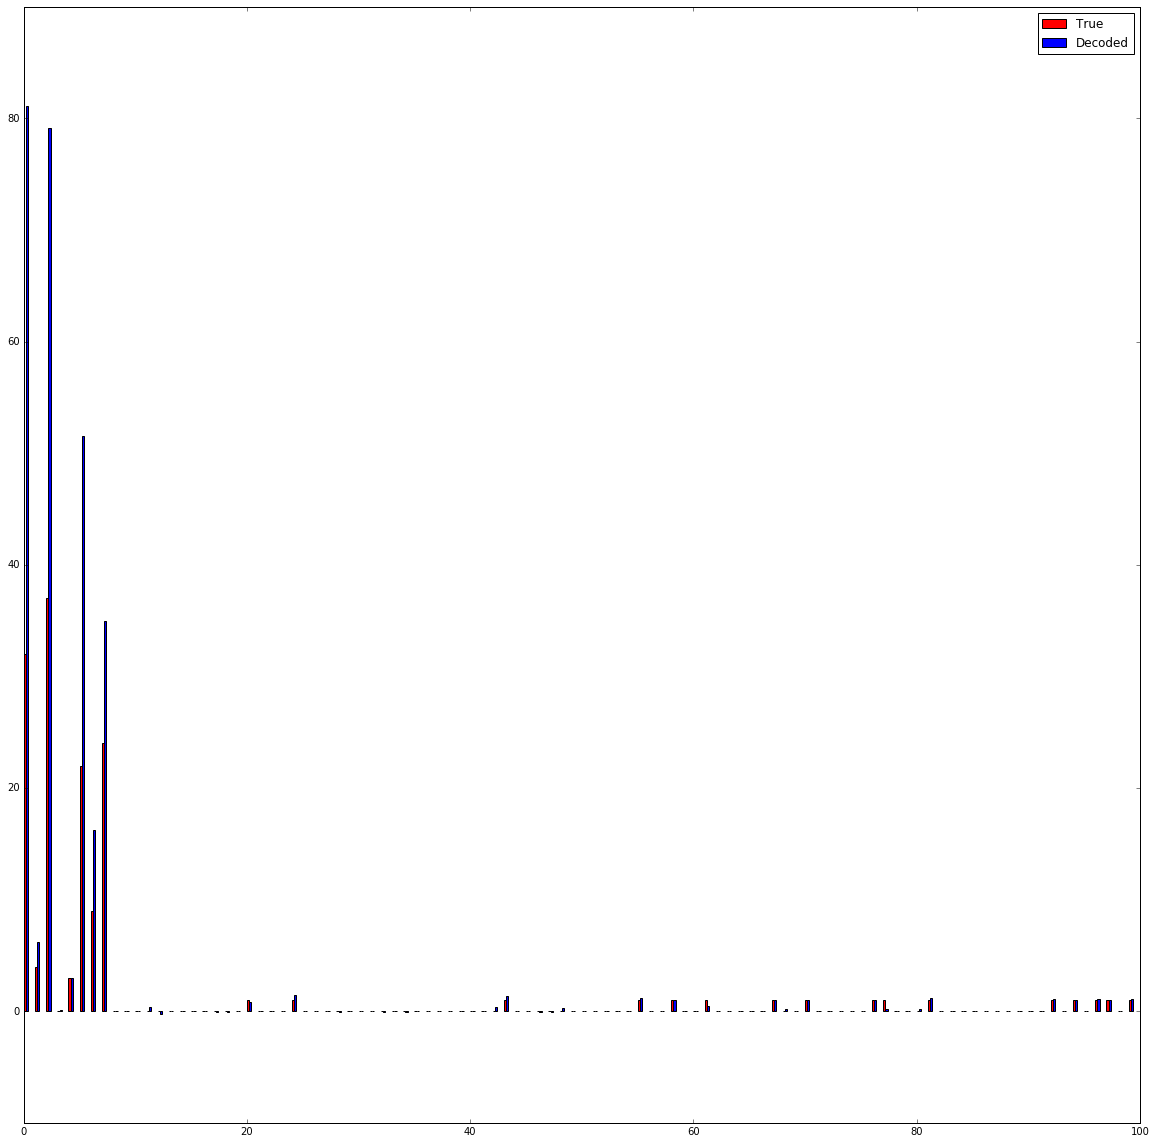

true size: (100,)
decoded size: (100,)


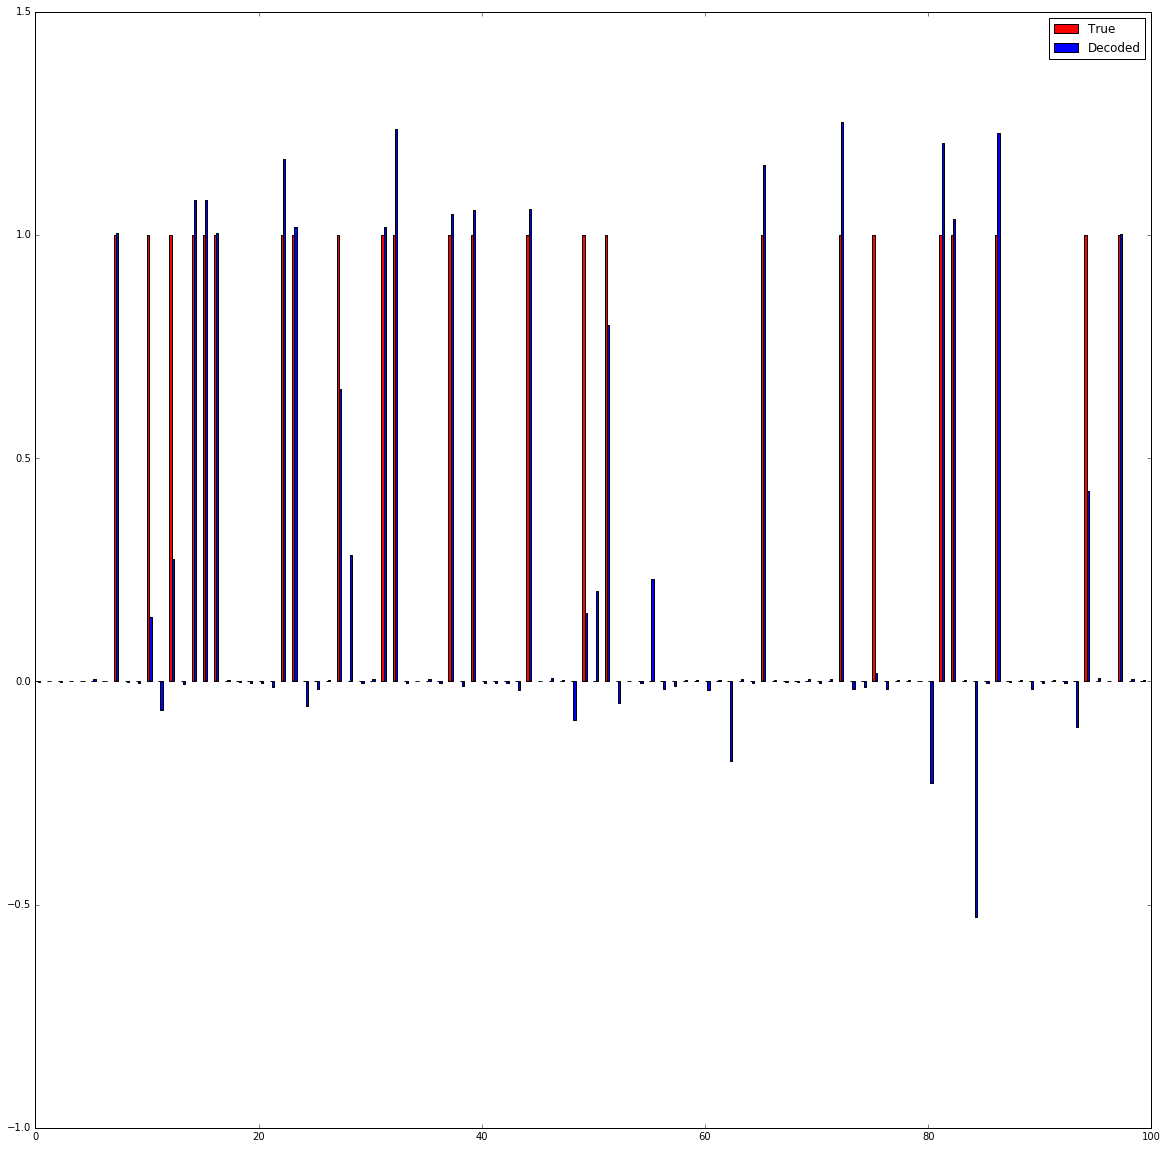

true size: (100,)
decoded size: (100,)


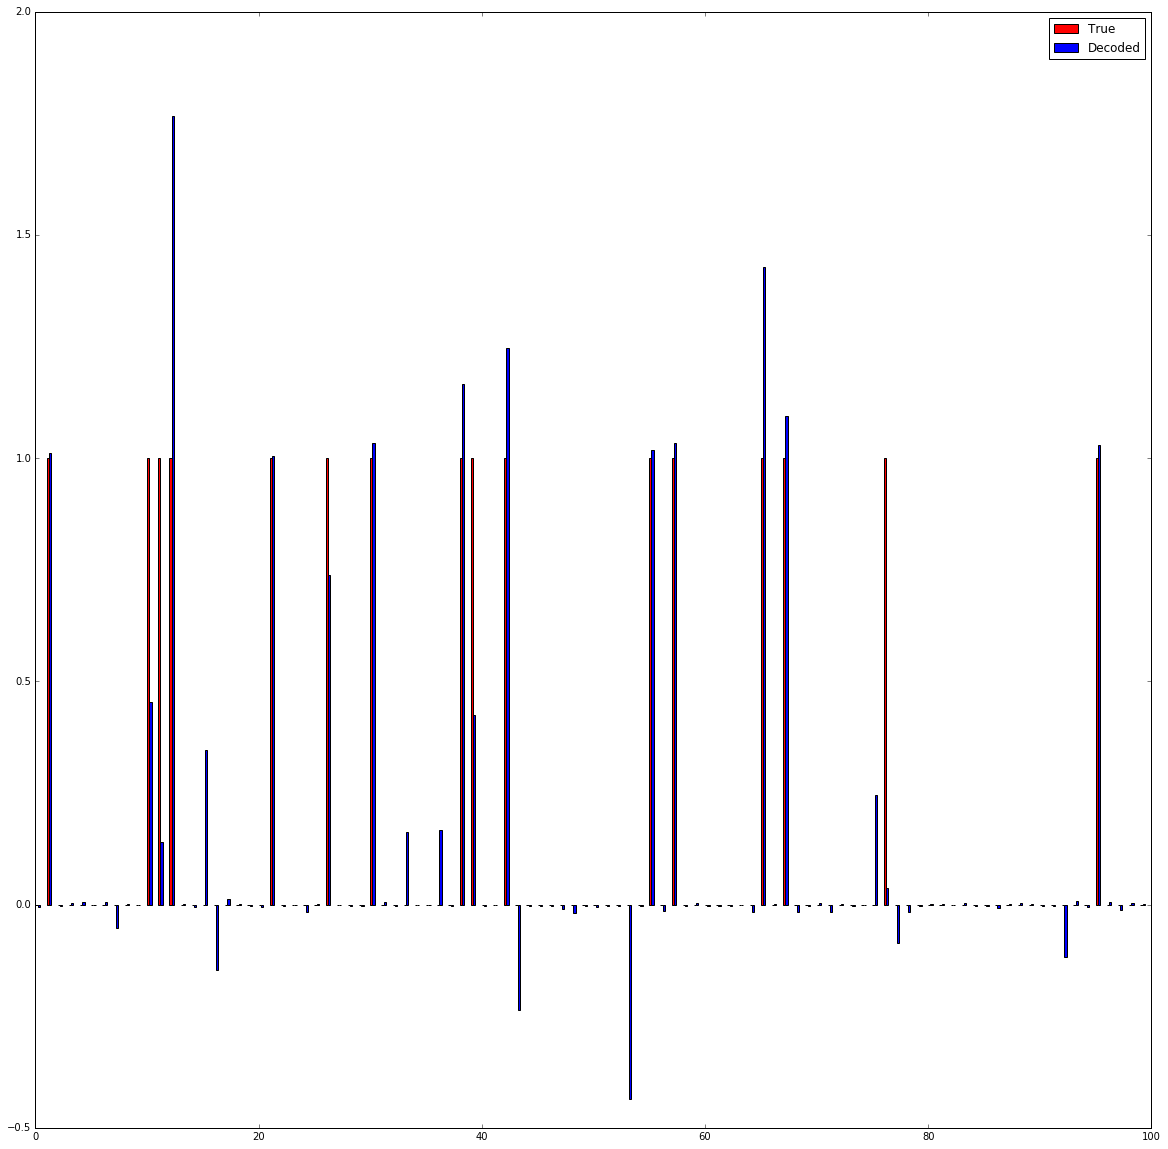

true size: (76,)
decoded size: (76,)


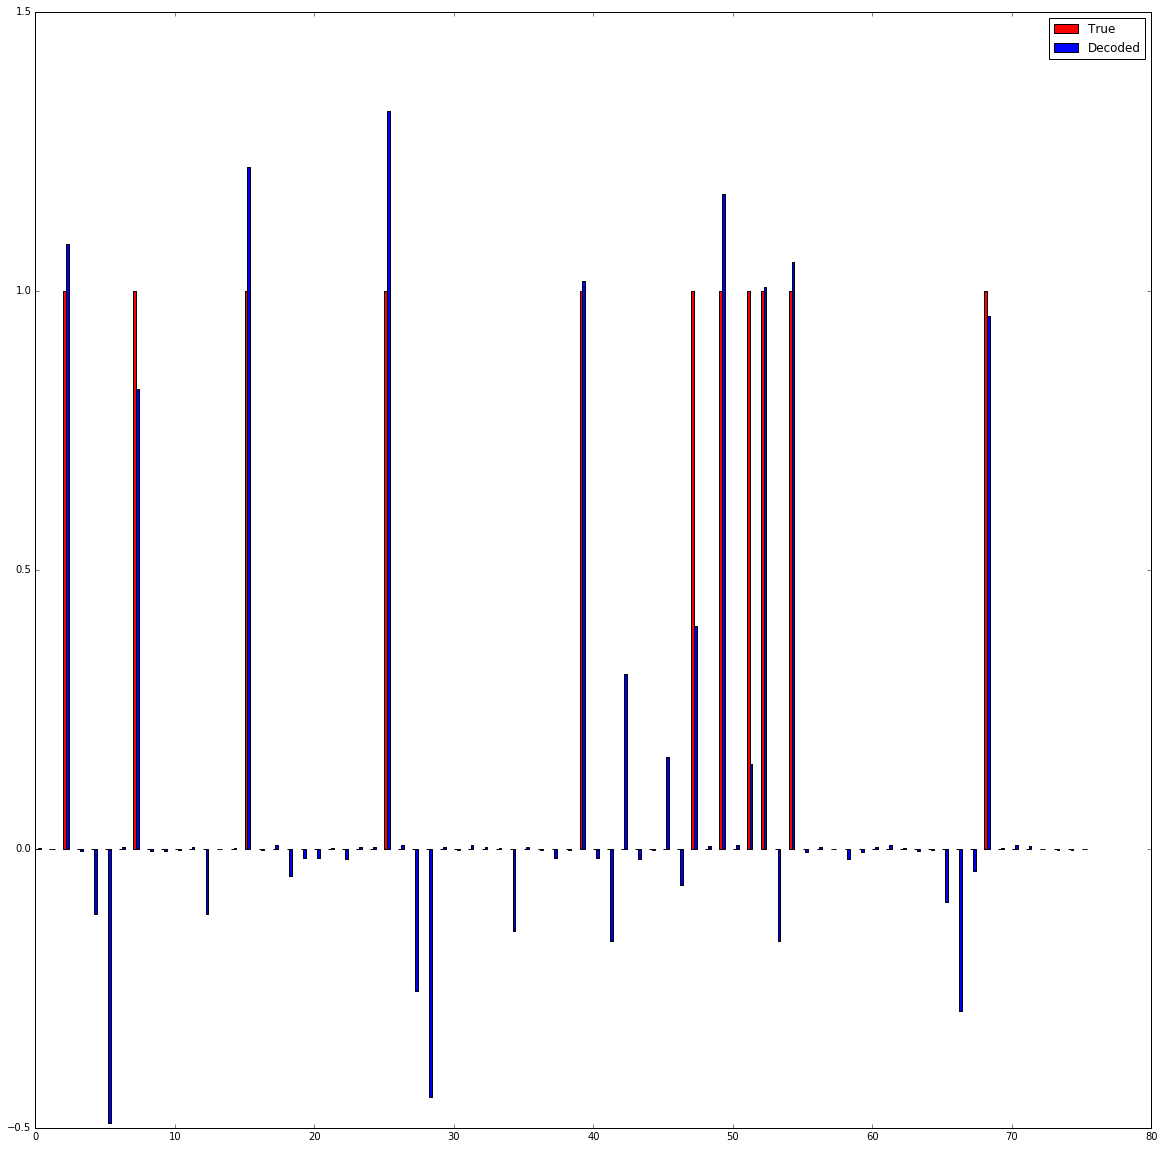

In [17]:
index_list = [65, 45, 46, 100]

for index in index_list:
    encode_decode(index)

###### Make new features

In [18]:
# Encode the featuers.
encoded_features = encoder.predict(features)
n_rows_nf, n_cols_nf = encoded_features.shape

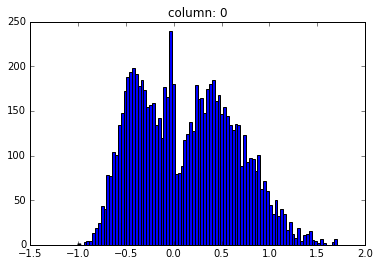

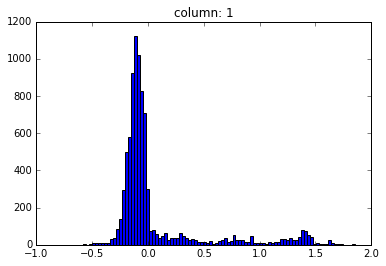

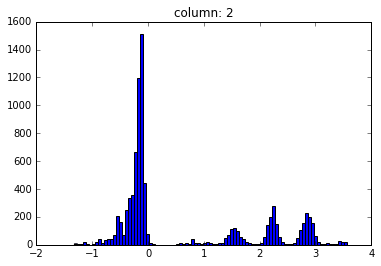

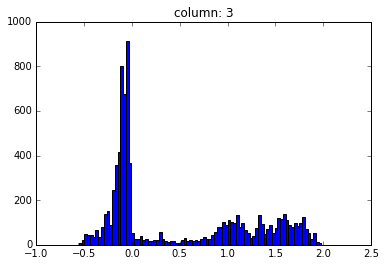

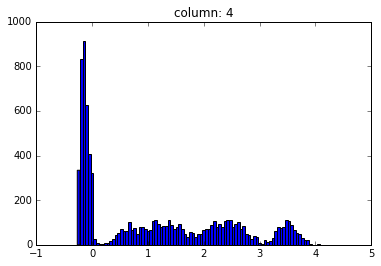

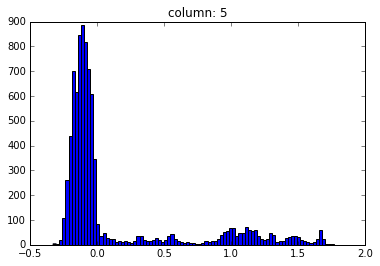

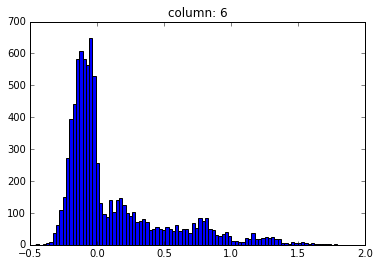

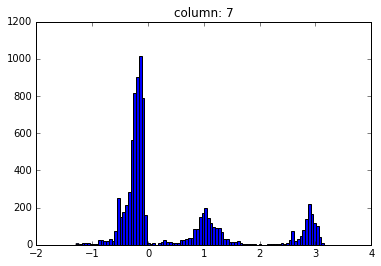

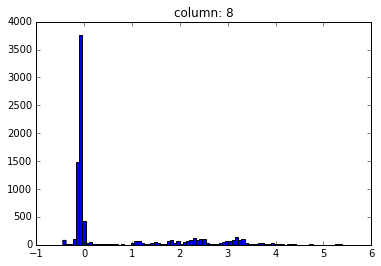

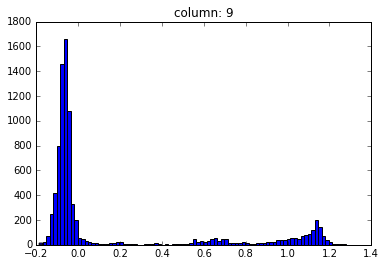

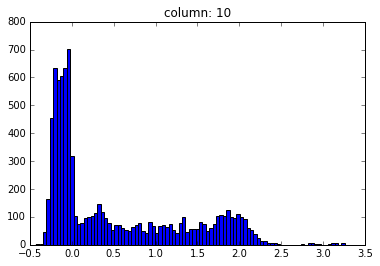

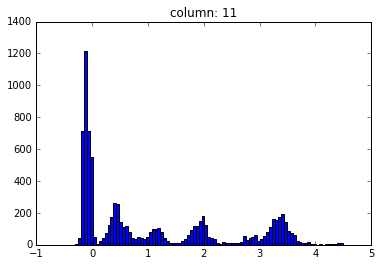

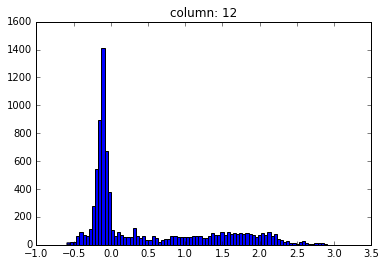

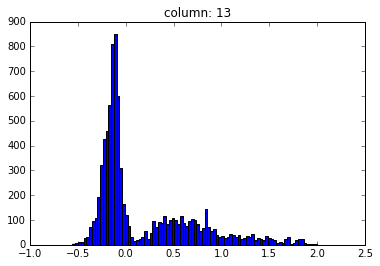

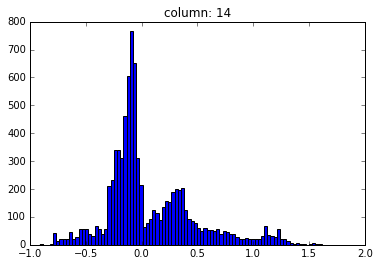

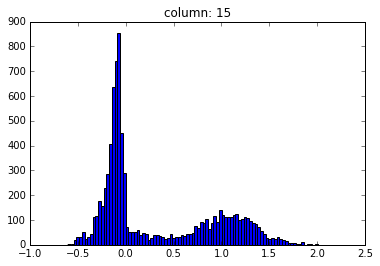

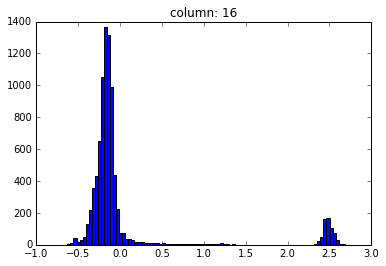

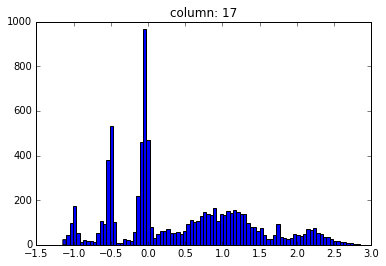

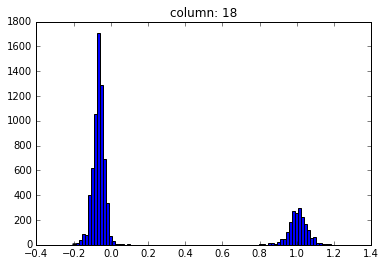

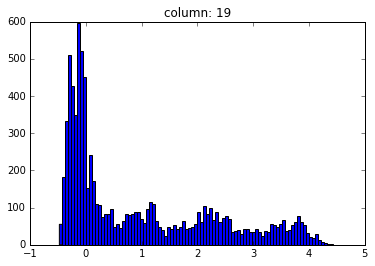

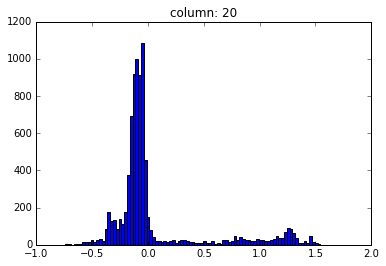

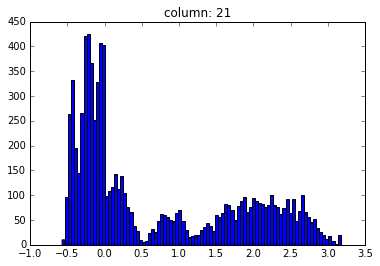

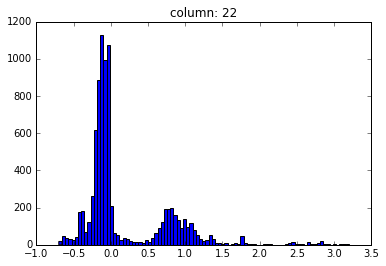

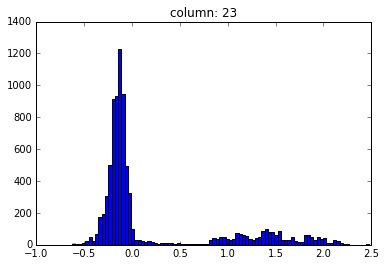

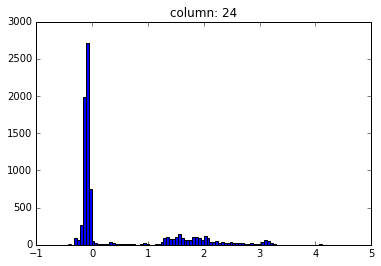

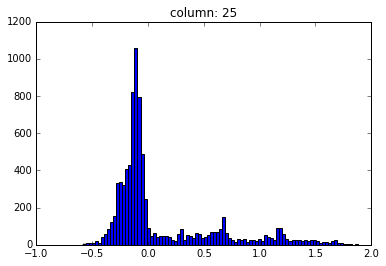

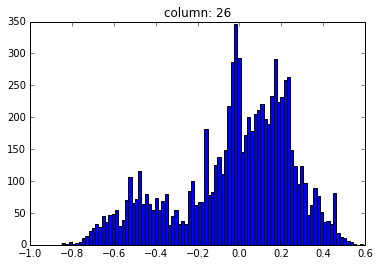

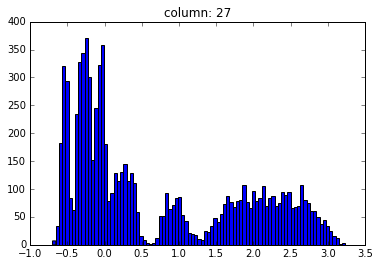

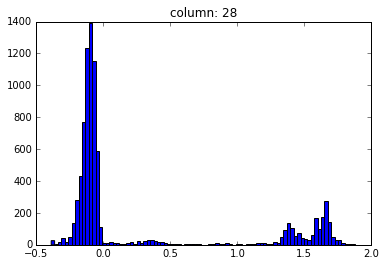

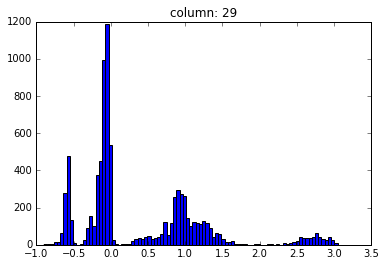

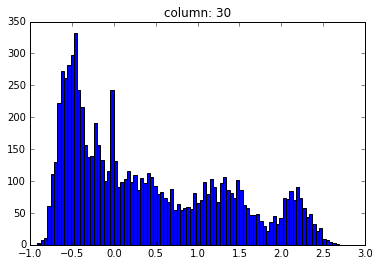

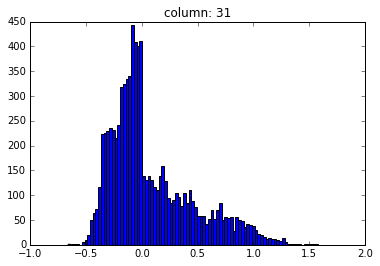

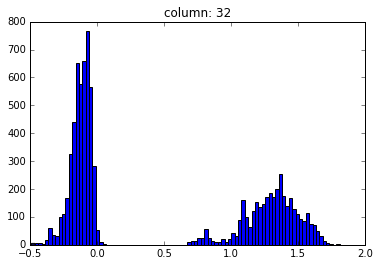

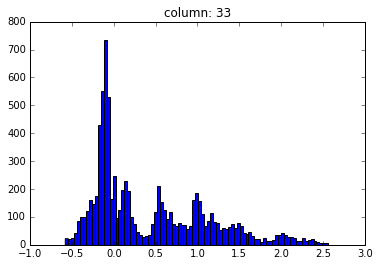

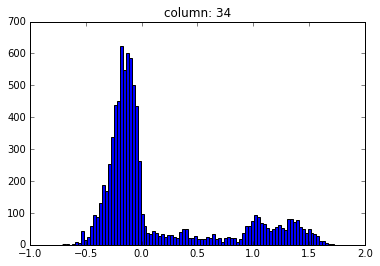

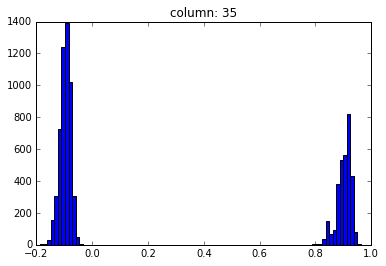

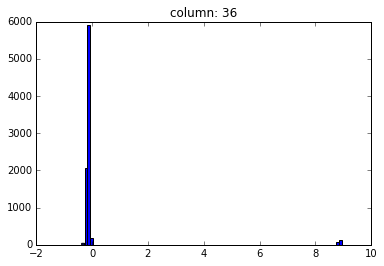

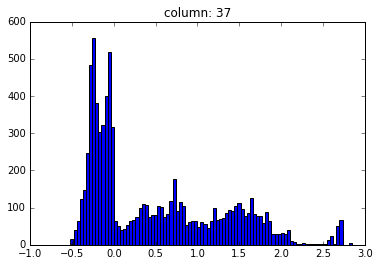

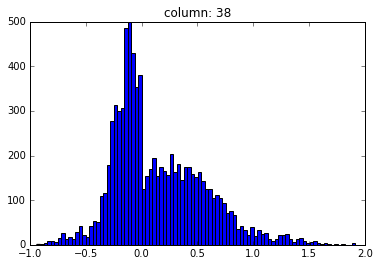

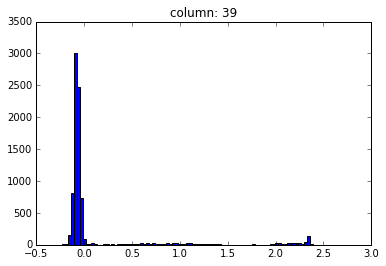

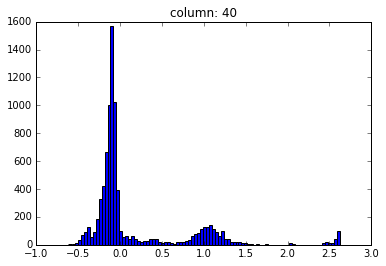

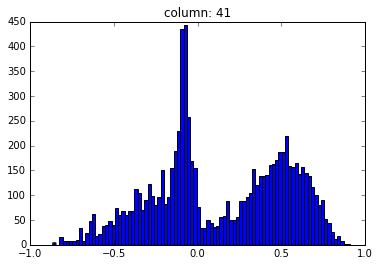

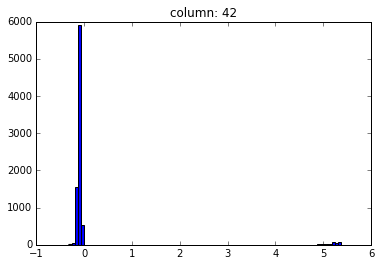

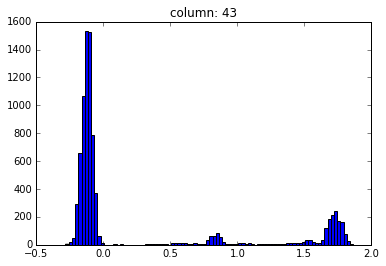

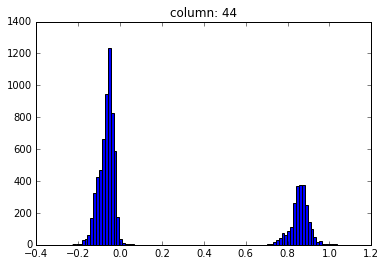

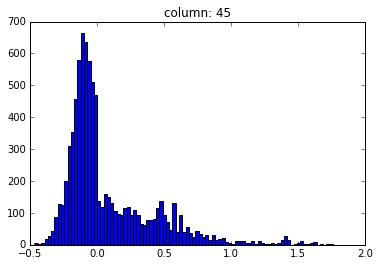

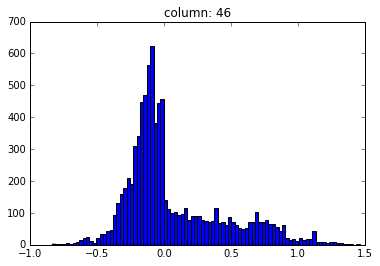

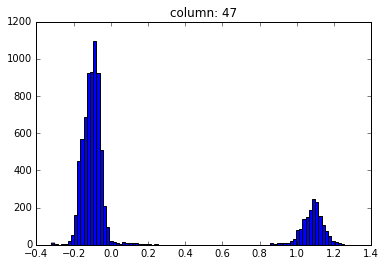

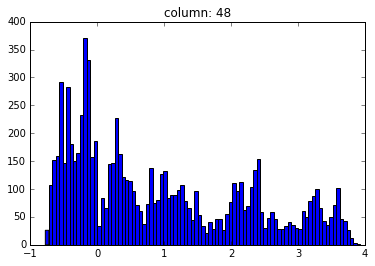

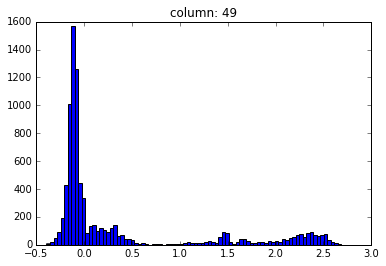

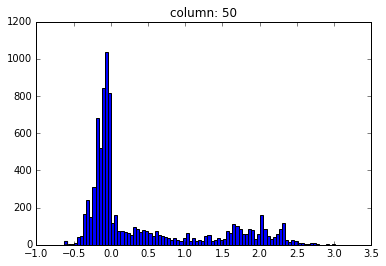

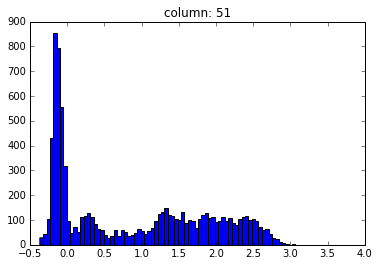

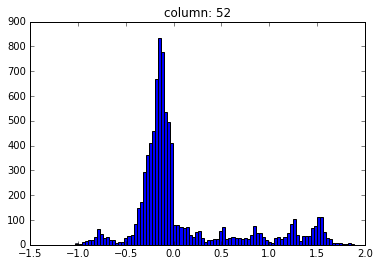

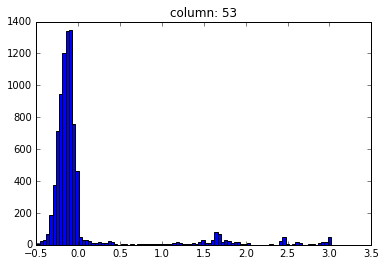

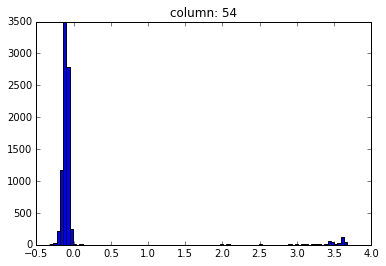

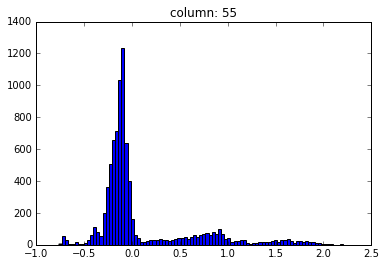

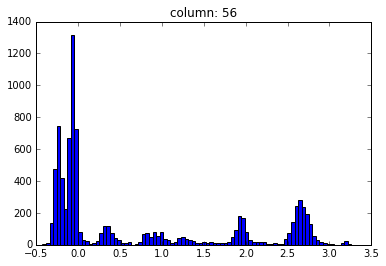

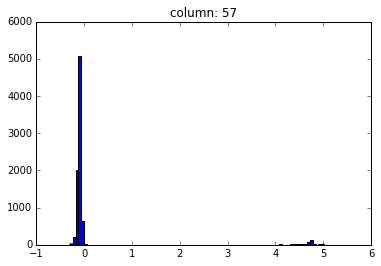

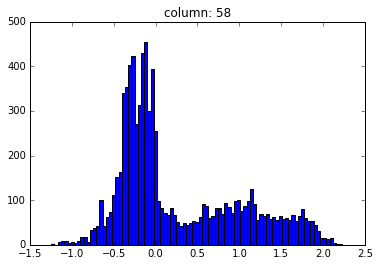

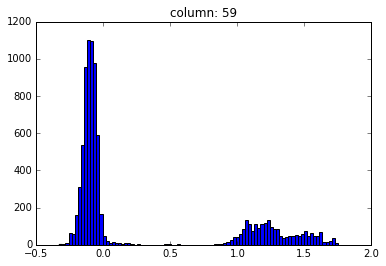

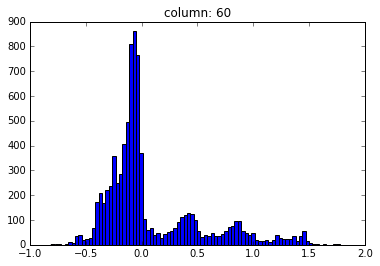

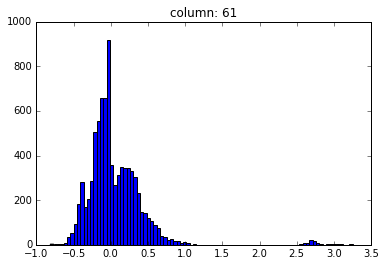

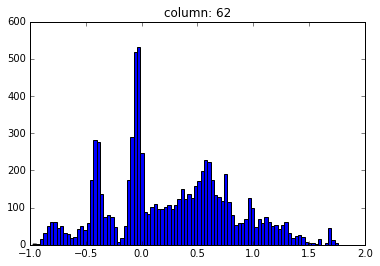

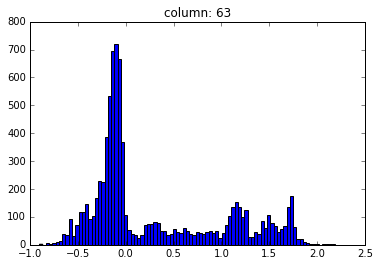

In [19]:
bins = int(np.sqrt(n_rows_nf))

for i in range(n_cols_nf):
    plt.hist(encoded_features[:,i].astype(np.float32), bins=bins)
    plt.title("column: " + str(i))
    plt.show()

###### Save the encoder

In [20]:
encoder_file_name = "encoder_dim_" + str(encoding_dim) + "_" + str(loss) + ".h5"
print("Encoder file name: " + str(encoder_file_name))
encoder.save(encoder_file_name)

Encoder file name: encoder_dim_64_mean_absolute_error.h5


###### Scratchpad

In [21]:
2946+1263

4209

In [22]:
2**10

1024

In [23]:
a = np.array([[1,2,3],[3,4,5],[4,5,6],[2,3,4]])

In [24]:
a.shape

(4, 3)

In [25]:
np.random.shuffle(a)

In [26]:
a

array([[1, 2, 3],
       [4, 5, 6],
       [2, 3, 4],
       [3, 4, 5]])

In [27]:
np.random.exponential()

1.9625000649702722

In [28]:
len(a)

4

In [29]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])